Датасет взят с сайта: https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn

Нужно создать модель машинного обучения с оптимизации по времени с предсказанием того уйдет ли клиент из банка по сроку действия (Tenure), установленный порог для классификации = 2. 

Проэксперементировать с другими порогами: [2, 1, 8, 7, 4, 6, 3, 10, 5, 9, 0]. 

Цель: создать модель машинного обучения (задача классификации) с метрикой по accuracy 89% и выше (посмотреть на recall и precision). 

In [241]:
#Импортируем нужные библиотеки
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from category_encoders.one_hot import OrdinalEncoder

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn import tree
import graphviz
import warnings
warnings.filterwarnings("ignore")

In [139]:
!pip install graphviz

In [140]:
!pip install category_encoders

In [141]:
df = pd.read_csv("Customer-Churn-Records.csv")

In [142]:
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


Для удобства заменим колонку RowNumber на id

In [143]:
cloumn_array = list(df.columns)
cloumn_array[0] = "id"
cloumn_array[:5]

['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography']

In [144]:
df.columns = cloumn_array

In [145]:
df.head(5)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [146]:
#Посмотрим на пороги, которые мы можем установить для классификации клиентов
df.Tenure.unique()

array([ 2,  1,  8,  7,  4,  6,  3, 10,  5,  9,  0], dtype=int64)

# Исследуем данные

Text(0.5, 1.0, 'Balance')

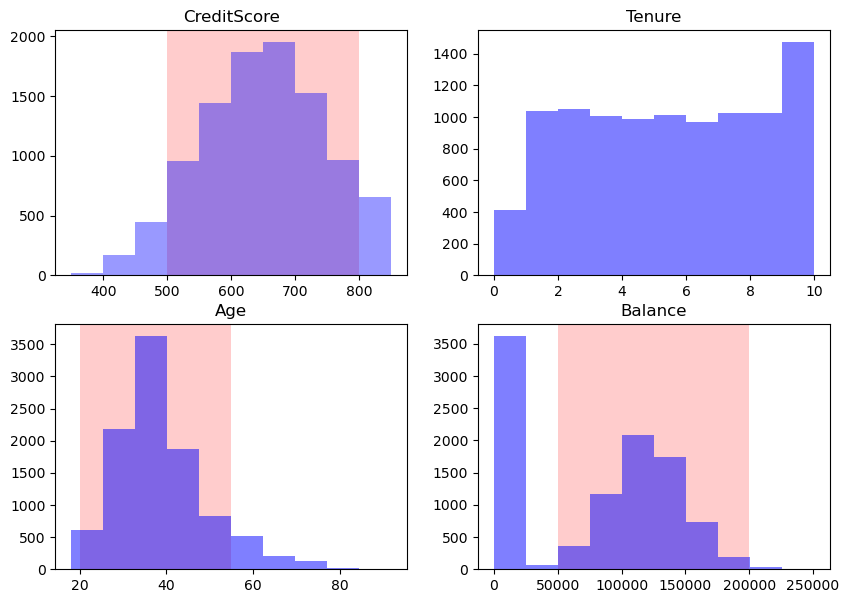

In [147]:
#Посмотрим на распределения некоторых данных

fig, axes = plt.subplots(2, 2, figsize=(10, 7))

axes[0][0].axvspan(500, 800, facecolor="red", alpha=0.2)
axes[0][0].hist(df['CreditScore'], color='blue', alpha=0.4, bins=10)
axes[0][0].set_title("CreditScore")

axes[0][1].hist(df['Tenure'], color='blue', alpha=0.5)
axes[0][1].set_title("Tenure")

axes[1][0].axvspan(20, 55, facecolor="red", alpha=0.2)
axes[1][0].hist(df['Age'], color='blue', alpha=0.5)
axes[1][0].set_title("Age")

axes[1][1].axvspan(50000, 200000, facecolor="red", alpha=0.2)
axes[1][1].hist(df['Balance'], color='blue', alpha=0.5)
axes[1][1].set_title("Balance")

In [148]:
def normal_func(data_value):
    """Функция проверяет переданный массив значений на нормальное распределение.
    Возвращает вердикт по распределению."""
    z_score, p_value = stats.normaltest(data_value)
    
    if p_value > 0.05:
        return f"Нет -> {round(p_value, 2)}"
    else:
        return f"Да -> {round(p_value, 2)}"

result_value_dict = {}

for item_name in ['CreditScore', 'Tenure', 'Age', 'Balance']:
    result_value_dict[item_name] = normal_func(df[item_name])

   
data_normalize_result = pd.DataFrame({'CreditScore ': [result_value_dict['CreditScore']],
              'Tenure ': [result_value_dict['Tenure']],
              'Age ': [result_value_dict['Age']],
              'Balance ': [result_value_dict['Balance']]})

data_normalize_result

,CreditScore,Tenure,Age,Balance
0,Да -> 0.0,Да -> 0.0,Да -> 0.0,Да -> 0.0


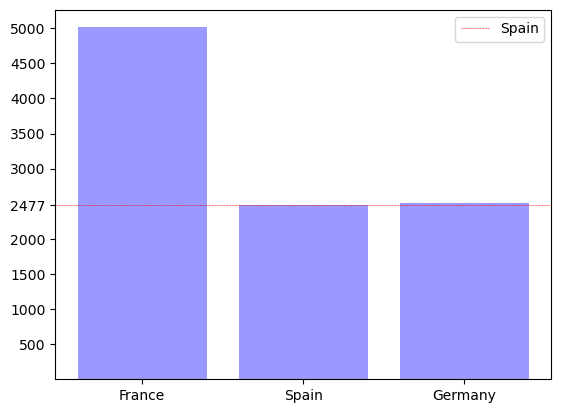

In [149]:
country = df['Geography'].unique()

country_array_count = []

for item_country in country:
    country_array_count.append(df[df['Geography'] == item_country]['Geography'].count())

plt.bar(country, country_array_count, color="blue", alpha=0.4)
plt.yticks([500, 1000, 1500, 2000, 2477, 3000, 3500, 4000, 4500, 5000], 
           labels=[500, 1000, 1500, 2000, 2477, 3000, 3500, 4000, 4500, 5000])
plt.axhline(y=2477, ls="--", label="Spain", linewidth=0.4, color='red')
plt.legend()

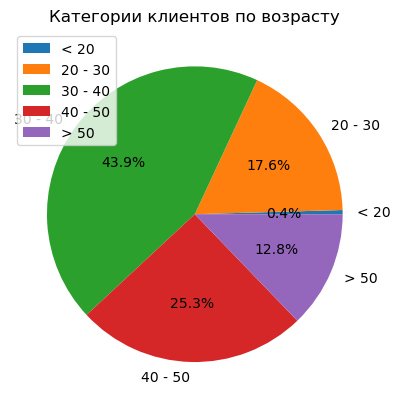

In [150]:
age_dict = {}
interval_age_dict = {}
labels_age = list(df['Age'])

for age_value in labels_age:
    age_dict[age_value] = df['Age'].value_counts()[age_value]

sum_age_interval_one = 0
# <20 - 1 категория 
for item_age in age_dict:
    if item_age < 20:
        sum_age_interval_one += age_dict[item_age]

sum_age_interval_two = 0
# 20-30 - 2 категория 
for item_age in age_dict:
    if item_age >= 20 and item_age <= 30:
        sum_age_interval_two += age_dict[item_age]
        
sum_age_interval_three = 0
# 30-40 - 3 категория 
for item_age in age_dict:
    if item_age >= 30 and item_age <= 40:
        sum_age_interval_three += age_dict[item_age]

sum_age_interval_four = 0
# 40-50 - 4 категория
for item_age in age_dict:
    if item_age >= 40 and item_age <= 50:
        sum_age_interval_four += age_dict[item_age]
        
sum_age_interval_five = 0
# >50 - 5 категория
for item_age in age_dict:
    if item_age >= 50:
        sum_age_interval_five += age_dict[item_age]
        
interval_age_dict['< 20'] = sum_age_interval_one
interval_age_dict['20 - 30'] = sum_age_interval_two
interval_age_dict['30 - 40'] = sum_age_interval_three
interval_age_dict['40 - 50'] = sum_age_interval_four
interval_age_dict['> 50'] = sum_age_interval_five

plt.pie(interval_age_dict.values(), labels=interval_age_dict.keys(), autopct='%1.1f%%')
plt.title("Категории клиентов по возрасту")
plt.legend()

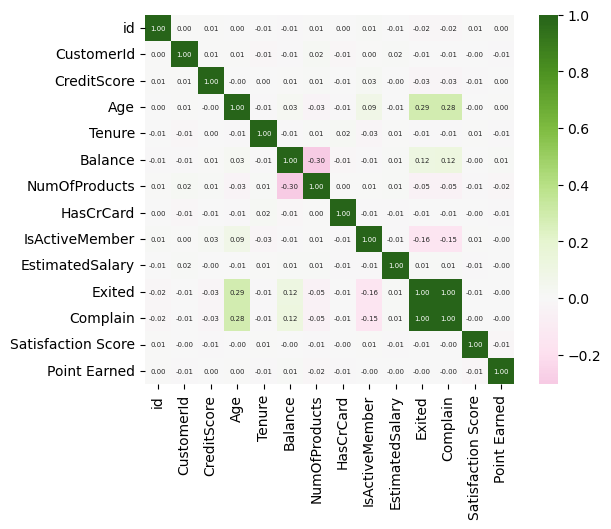

In [151]:
sns.heatmap(data=df.corr(),
            square=True, cmap="PiYG", 
            center=0,
            annot=True, fmt='.2f', annot_kws={'size': 5});

Максимальная корреляция между признаками составляет 0.29, что по таблице корреляции (Шкалла Чеддока) ознается слабую положительную связь, поэтому мы не можем сжать наш датасет, удалив одну из фичей Exited или Complain, или Age, заменив тем самым на 1 переменную.

In [152]:
data_null = df.isnull()
columns = list(data_null.columns)
null_dict_result = {}

for column in columns:
    null_dict_result[column] = data_null[data_null[column] == True][column].count()

null_dict_result

{'id': 0,
 'CustomerId': 0,
 'Surname': 0,
 'CreditScore': 0,
 'Geography': 0,
 'Gender': 0,
 'Age': 0,
 'Tenure': 0,
 'Balance': 0,
 'NumOfProducts': 0,
 'HasCrCard': 0,
 'IsActiveMember': 0,
 'EstimatedSalary': 0,
 'Exited': 0,
 'Complain': 0,
 'Satisfaction Score': 0,
 'Card Type': 0,
 'Point Earned': 0}

Пустых значений в датасете нет

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

In [154]:
data_int = df[['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited', 'Complain', 'Satisfaction Score', 'Point Earned']]
data_int.head()

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Exited,Complain,Satisfaction Score,Point Earned
0,619,42,2,1,1,1,1,1,2,464
1,608,41,1,1,0,1,0,1,3,456
2,502,42,8,3,1,0,1,1,3,377
3,699,39,1,2,0,0,0,0,5,350
4,850,43,2,1,1,1,0,0,5,425


In [155]:
data_int.describe()

,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Exited,Complain,Satisfaction Score,Point Earned
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,1.530200,0.70550,0.515100,0.203800,0.204400,3.013800,606.515100
std,96.653299,10.487806,2.892174,0.581654,0.45584,0.499797,0.402842,0.403283,1.405919,225.924839
min,350.000000,18.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,1.000000,119.000000
25%,584.000000,32.000000,3.000000,1.000000,0.00000,0.000000,0.000000,0.000000,2.000000,410.000000
50%,652.000000,37.000000,5.000000,1.000000,1.00000,1.000000,0.000000,0.000000,3.000000,605.000000
75%,718.000000,44.000000,7.000000,2.000000,1.00000,1.000000,0.000000,0.000000,4.000000,801.000000
max,850.000000,92.000000,10.000000,4.000000,1.00000,1.000000,1.000000,1.000000,5.000000,1000.000000


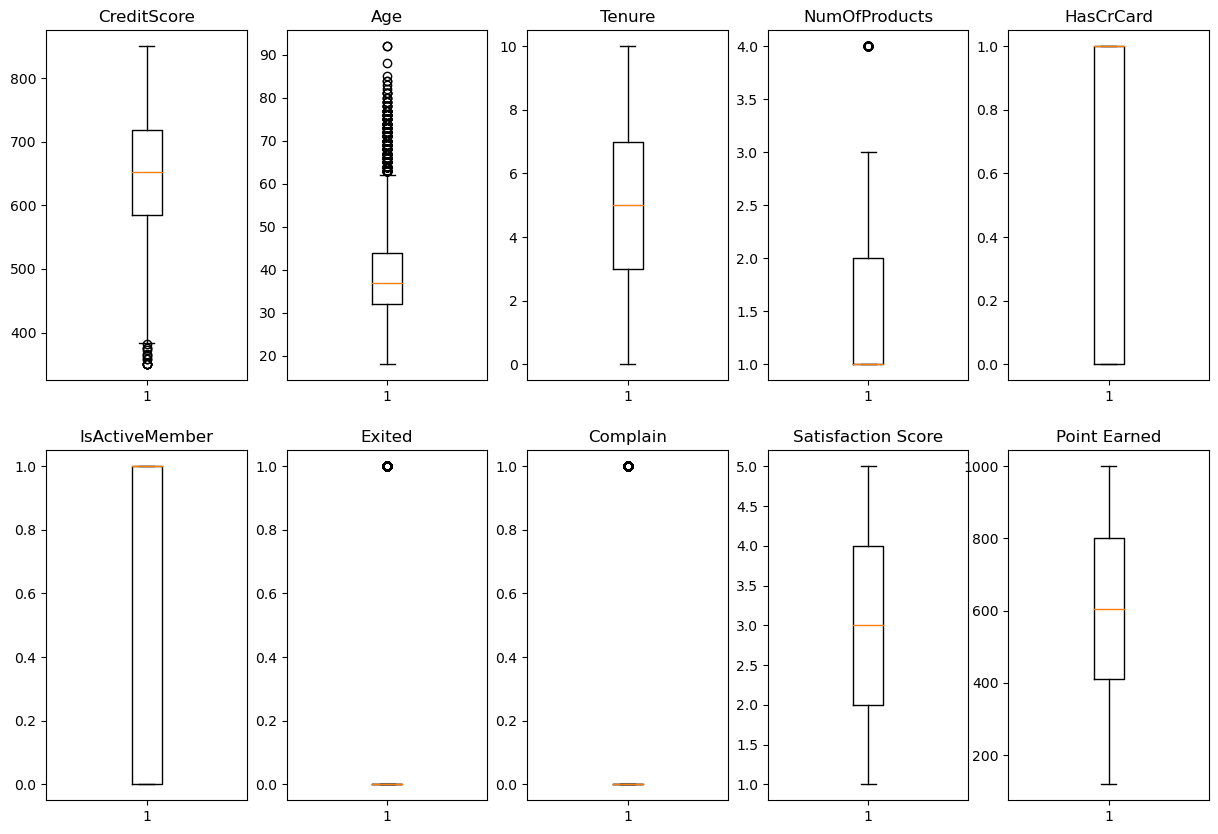

In [156]:
columns = list(data_int.columns)
fig, axes = plt.subplots(2, int(len(columns)/2), figsize=(15, 10))

iter_ = 0 
for column in columns:
    if iter_ <= 4:
        axes[0][iter_].boxplot(data_int[column])
        axes[0][iter_].set_title(column)
        iter_ += 1
    else:
        axes[1][iter_-5].boxplot(data_int[column])
        axes[1][iter_-5].set_title(column)
        iter_ += 1

In [157]:
data_int['NumOfProducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

Попробуем на алгоритме RandomForestClassifier отобрать информативные признаки для задачи классификации и других алгоритмов, возьмем только числовые признаки, посмотрим результат, далее закодируем кодигориальные признаки, после чего также посмотрим результаты вместе с ними

In [158]:
model_random_forest = RandomForestClassifier()

X = data_int[['CreditScore', 'Age', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
              'Exited', 'Complain', 'Satisfaction Score', 'Point Earned']]
y = data_int['Tenure']
model_random_forest.fit(X, y)

RandomForestClassifier()

In [159]:
columns = ['CreditScore', 'Age', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 
           'Exited', 'Complain', 'Satisfaction Score', 'Point Earned']

importances_feature = model_random_forest.feature_importances_

feature_inmportances_dict = {}

for feature_item in range(len(columns)):
    feature_inmportances_dict[columns[feature_item]] = round(importances_feature[feature_item], 4)

feature_inmportances_dict

{'CreditScore': 0.2905,
 'Age': 0.2229,
 'NumOfProducts': 0.0272,
 'HasCrCard': 0.0256,
 'IsActiveMember': 0.0288,
 'Exited': 0.0085,
 'Complain': 0.0085,
 'Satisfaction Score': 0.089,
 'Point Earned': 0.299}

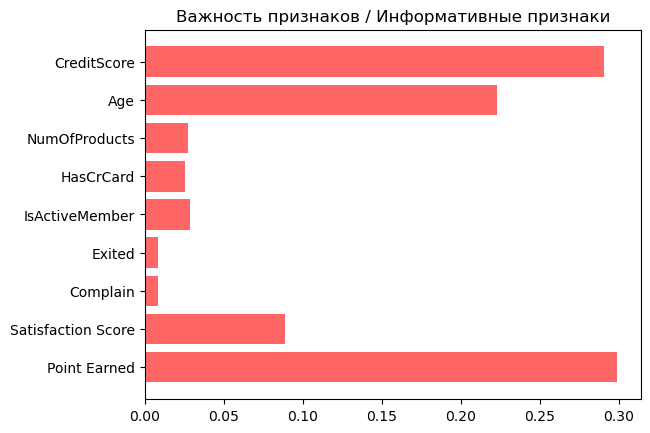

In [160]:
plt.title("Важность признаков / Информативные признаки")
plt.barh(list(feature_inmportances_dict.keys()), list(feature_inmportances_dict.values()), alpha=0.6, color='red')
plt.gca().invert_yaxis()

Теперь мы можем попробовать обучить модели на самых важных признаках из разряда числовых, посмотреть на метрики (в нашем случае целевая - это accuracy, но посмотрим и на другие), построим ROC AUC кривую.
Важные признаки: CreditScore, Age, NumOfProducts, HasCrCard, IsActiveMember, Satisfaction Score, Point Earned.
Теперь закодируем категориальные признаки и посморим на важность признаков в совокупности с теми, которые мы рассмотрели выше. Плюс нужно проверить гипотезу на то, является ли значение из NumOfProducts выбросом (которое отмечено на графике boxplot)

In [161]:
df[['Surname', 'Geography', 'Gender', 'Card Type']].head() #категориальные признаки

,Surname,Geography,Gender,Card Type
0,Hargrave,France,Female,DIAMOND
1,Hill,Spain,Female,DIAMOND
2,Onio,France,Female,DIAMOND
3,Boni,France,Female,GOLD
4,Mitchell,Spain,Female,GOLD


In [162]:
ord_enc = OrdinalEncoder()
data_enc = df[['Surname', 'Geography', 'Gender', 'Card Type']]
data_enc['id'] = [item for item in range(len(data_enc))]
data_enc = ord_enc.fit_transform(data_enc)
data_enc

,Surname,Geography,Gender,Card Type,id
0,1,1,1,1,0
1,2,2,1,1,1
2,3,1,1,1,2
3,4,1,1,2,3
4,5,2,1,2,4
...,...,...,...,...,...
9995,2540,1,2,1,9995
9996,607,1,2,4,9996
9997,906,1,1,3,9997
9998,1784,3,2,2,9998


In [163]:
data_all = df[['CreditScore', 'Age', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
              'Exited', 'Complain', 'Satisfaction Score', 'Point Earned', 'Tenure']]
data_all['id'] = [item for item in range(len(data_int))]
data_all.head()

,CreditScore,Age,NumOfProducts,HasCrCard,IsActiveMember,Exited,Complain,Satisfaction Score,Point Earned,Tenure,id
0,619,42,1,1,1,1,1,2,464,2,0
1,608,41,1,0,1,0,1,3,456,1,1
2,502,42,3,1,0,1,1,3,377,8,2
3,699,39,2,0,0,0,0,5,350,1,3
4,850,43,1,1,1,0,0,5,425,2,4


In [164]:
data_result = pd.merge(data_enc, data_all, left_on=['id'], right_on=['id'], how="inner")
data_result.head()

,Surname,Geography,Gender,Card Type,id,CreditScore,Age,NumOfProducts,HasCrCard,IsActiveMember,Exited,Complain,Satisfaction Score,Point Earned,Tenure
0,1,1,1,1,0,619,42,1,1,1,1,1,2,464,2
1,2,2,1,1,1,608,41,1,0,1,0,1,3,456,1
2,3,1,1,1,2,502,42,3,1,0,1,1,3,377,8
3,4,1,1,2,3,699,39,2,0,0,0,0,5,350,1
4,5,2,1,2,4,850,43,1,1,1,0,0,5,425,2


In [165]:
X = data_result[['Card Type', 'Gender', 'Geography', 'Surname', 'CreditScore', 'Age', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
              'Exited', 'Complain', 'Satisfaction Score', 'Point Earned']]
y = data_result['Tenure']

model_random_forest.fit(X, y)

RandomForestClassifier()

In [166]:
columns = ['Card Type', 'Gender', 'Geography', 'Surname', 'CreditScore', 
           'Age', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
           'Exited', 'Complain', 'Satisfaction Score', 'Point Earned']

importances_feature = model_random_forest.feature_importances_

feature_inmportances_dict = {}

for feature_item in range(len(columns)):
    feature_inmportances_dict[columns[feature_item]] = round(importances_feature[feature_item], 4)

feature_inmportances_dict

{'Card Type': 0.0653,
 'Gender': 0.0295,
 'Geography': 0.0429,
 'Surname': 0.1775,
 'CreditScore': 0.1736,
 'Age': 0.1535,
 'NumOfProducts': 0.0294,
 'HasCrCard': 0.0289,
 'IsActiveMember': 0.0276,
 'Exited': 0.0097,
 'Complain': 0.0097,
 'Satisfaction Score': 0.075,
 'Point Earned': 0.1774}

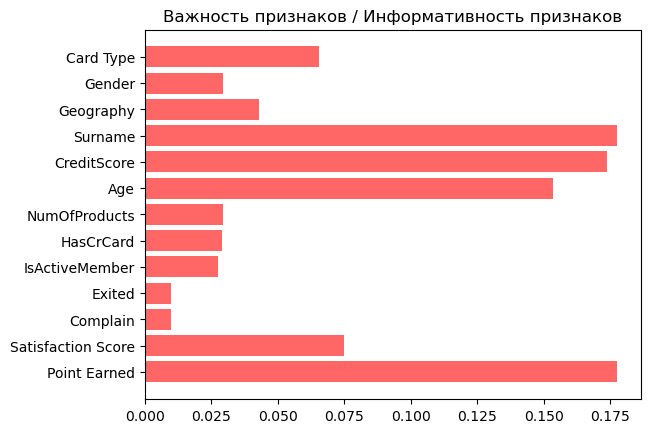

In [167]:
plt.title("Важность признаков / Информативность признаков")
plt.barh(list(feature_inmportances_dict.keys()), list(feature_inmportances_dict.values()), alpha=0.6, color='red')
plt.gca().invert_yaxis()

Таким образом, мы получили еще пайплайн информативных признаков, после применения кодирования к категориальным признакам: 
    
    Самые информативные фичи: Card Type, Gender, Geography, Surname, CreditScore, Age, Satisfaction Score, Point Earned
    
    Менее информативные фичи: NumOfProducts, HasCrCard, IsActiveMember, Exited, Complain

Зададим порог для классификации равный значению, которое встречается чаще всего в целевой переменной

In [168]:
df['Tenure'].value_counts()

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64

In [169]:
max(list(df['Tenure'].value_counts()))

1048

Самое частое значение, которое встречается - это значение 2, поэтому установим это как порог классификации

In [170]:
data_all.head()

,CreditScore,Age,NumOfProducts,HasCrCard,IsActiveMember,Exited,Complain,Satisfaction Score,Point Earned,Tenure,id
0,619,42,1,1,1,1,1,2,464,2,0
1,608,41,1,0,1,0,1,3,456,1,1
2,502,42,3,1,0,1,1,3,377,8,2
3,699,39,2,0,0,0,0,5,350,1,3
4,850,43,1,1,1,0,0,5,425,2,4


In [171]:
def func_classifier(value):
    if value == 2: 
        return 1
    else:
        return 0
    
data_result['Tenure_value'] = data_all['Tenure'].apply(func_classifier)

In [172]:
data_result.head(5)

,Surname,Geography,Gender,Card Type,id,CreditScore,Age,NumOfProducts,HasCrCard,IsActiveMember,Exited,Complain,Satisfaction Score,Point Earned,Tenure,Tenure_value
0,1,1,1,1,0,619,42,1,1,1,1,1,2,464,2,1
1,2,2,1,1,1,608,41,1,0,1,0,1,3,456,1,0
2,3,1,1,1,2,502,42,3,1,0,1,1,3,377,8,0
3,4,1,1,2,3,699,39,2,0,0,0,0,5,350,1,0
4,5,2,1,2,4,850,43,1,1,1,0,0,5,425,2,1


Обучим линейную регрессию, посмотрим на метрики, разобьем датасет на трейн и тест

In [173]:
%%time

X = data_result[['Card Type', 'Gender', 'Geography', 'Surname', 'CreditScore', 'Age', 'Satisfaction Score', 'Point Earned']]
Y = data_result['Tenure_value']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=17)

model_logistic_more_informative_features = LogisticRegression().fit(x_train, y_train)

CPU times: total: 62.5 ms
Wall time: 65.1 ms


In [174]:
y_pred = model_logistic_more_informative_features.predict(x_test)

In [175]:
accuracy_score(y_pred, y_test)

0.8975

In [176]:
roc_auc_score(y_test, y_pred)

0.5

In [177]:
%%time

X = data_result[['Complain', 'Exited', 'IsActiveMember', 'HasCrCard', 'NumOfProducts', 'Card Type', 'Gender', 'Geography', 'Surname', 'CreditScore', 'Age', 'Satisfaction Score', 'Point Earned']]
Y = data_result['Tenure_value']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=17)

model_logistic_all_features = LogisticRegression().fit(x_train, y_train)

CPU times: total: 93.8 ms
Wall time: 99.3 ms


In [178]:
y_pred_two = model_logistic_all_features.predict(x_test)

In [179]:
accuracy_score(y_pred_two, y_test)

0.8975

In [180]:
roc_auc_score(y_test, y_pred_two)

0.5

Видим, что итоговый скор одинаковый -> мы отобрали верные инфомативные признаки, оптимизировали время с 164 ms до 88.6 ms

In [181]:
df_result_model = pd.DataFrame([['model_logistic_more_informative_features','0.5', '0.8975', '88.6 ms', '78.1 ms'],
             ['model_logistic_all_features', '0.5','0.8975', '164 ms', '172 ms']])

df_result_model

,0,1,2,3,4
0,model_logistic_more_informative_features,0.5,0.8975,88.6 ms,78.1 ms
1,model_logistic_all_features,0.5,0.8975,164 ms,172 ms


In [182]:
df_result_model.columns = ['model', 'roc_auc_score', 'accuracy_score', 'Wall time', 'CPU times']

In [183]:
df_result_model

,model,roc_auc_score,accuracy_score,Wall time,CPU times
0,model_logistic_more_informative_features,0.5,0.8975,88.6 ms,78.1 ms
1,model_logistic_all_features,0.5,0.8975,164 ms,172 ms


Так как наша KPI метрика - это accuracy_score, то она равна 90%, если округлить, это значит, что мы ошибочно прогнозируем 10% данных -> потенциально теряем 10% клиентов, а значит если наша общее число клиентов равно 1.000.000, то мы потенциально теряем 100.000 клиентов из-за неправильного прогноза, таким образом, нам нужно улучшить accuracy_score минимум до 95%

Что можно сделать: 
    
    1. Использовать другую модель
    
    2. Создать более информативный признак на основе имеющихся 
    
    3. Покрутить гиперпараметры других моделей 
    
    4. Использовать ансамбль моделей 
    
    5. Поработать более лучше с данными, например, понизить размерность или привести к одному масштабу, если он сильно различается
    
    6. Поработать с кросс-валидацей, поразбивать датасет на фолды, разными методами, посмотреть на итоговый скор

Попробуем другие модели, в качестве фичей будем брать те, которые показали лучшее время

In [184]:
accuracy_score_dict = {'3':'0.871', '4':'0.871', '5':'0.871'}
roc_auc_score_dict = {'3':'0.496', '4':'0.496', '5':'0.496'}

wall_time = {'3':'21 ms', '4':'35.1 ms', '5':'27 ms'}
cpu_time = {'3':'15.6 ms', '4':'62.5 ms', '5':'31.2 ms'}

X = data_result[['Card Type', 'Gender', 'Geography', 'Surname', 'CreditScore', 'Age', 'Satisfaction Score', 'Point Earned']]
Y = data_result['Tenure_value']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=17)

In [185]:
%%time

knn_model_3 = KNeighborsClassifier(n_neighbors=3).fit(x_train, y_train)

CPU times: total: 31.2 ms
Wall time: 29.2 ms


In [186]:
%%time

knn_model_4 = KNeighborsClassifier(n_neighbors=3).fit(x_train, y_train)

CPU times: total: 46.9 ms
Wall time: 30.1 ms


In [187]:
%%time

knn_model_5 = KNeighborsClassifier(n_neighbors=3).fit(x_train, y_train)

CPU times: total: 15.6 ms
Wall time: 42.2 ms


In [188]:
y_pred_3 = knn_model_3.predict(x_test)
y_pred_4 = knn_model_4.predict(x_test)
y_pred_5 = knn_model_5.predict(x_test)

In [189]:
accuracy_score(y_test, y_pred_3)

0.871

In [190]:
accuracy_score(y_test, y_pred_4)

0.871

In [191]:
accuracy_score(y_test, y_pred_5)

0.871

In [192]:
roc_auc_score(y_test, y_pred_3)

0.4960391330932808

In [193]:
roc_auc_score(y_test, y_pred_4)

0.4960391330932808

In [194]:
roc_auc_score(y_test, y_pred_5)

0.4960391330932808

In [195]:
df_result_model

,model,roc_auc_score,accuracy_score,Wall time,CPU times
0,model_logistic_more_informative_features,0.5,0.8975,88.6 ms,78.1 ms
1,model_logistic_all_features,0.5,0.8975,164 ms,172 ms


In [196]:
data_knn = pd.DataFrame([['knn_model_3', roc_auc_score_dict['3'], accuracy_score_dict['3'], wall_time['3'], cpu_time['3']],
              ['knn_model_4', roc_auc_score_dict['4'], accuracy_score_dict['4'], wall_time['4'], cpu_time['4']],
              ['knn_model_5', roc_auc_score_dict['5'], accuracy_score_dict['5'], wall_time['5'], cpu_time['5']]])


data_knn.columns = ['model', 'roc_auc_score', 'accuracy_score', 'Wall time', 'CPU times']

data_knn

,model,roc_auc_score,accuracy_score,Wall time,CPU times
0,knn_model_3,0.496,0.871,21 ms,15.6 ms
1,knn_model_4,0.496,0.871,35.1 ms,62.5 ms
2,knn_model_5,0.496,0.871,27 ms,31.2 ms


In [197]:
df_result_model = df_result_model.append(data_knn)
df_result_model

,model,roc_auc_score,accuracy_score,Wall time,CPU times
0,model_logistic_more_informative_features,0.5,0.8975,88.6 ms,78.1 ms
1,model_logistic_all_features,0.5,0.8975,164 ms,172 ms
0,knn_model_3,0.496,0.871,21 ms,15.6 ms
1,knn_model_4,0.496,0.871,35.1 ms,62.5 ms
2,knn_model_5,0.496,0.871,27 ms,31.2 ms


In [198]:
#Попробуем нативный байесовский классификатор 
nb_gaussianNB = GaussianNB()

X = data_result[['Card Type', 'Gender', 'Geography', 'Surname', 'CreditScore', 'Age', 'Satisfaction Score', 'Point Earned']]
Y = data_result['Tenure_value']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=17)

nb_gaussianNB.fit(x_train, y_train)

GaussianNB()

In [199]:
%%time

nb_gaussianNB.fit(x_train, y_train)

CPU times: total: 15.6 ms
Wall time: 10.2 ms


GaussianNB()

In [200]:
y_pred_nb = nb_gaussianNB.predict(x_test)

In [201]:
print(f"accuracy = {accuracy_score(y_test, y_pred_nb)}, roc_auc_score = {roc_auc_score(y_test, y_pred_nb)}")

accuracy = 0.8975, roc_auc_score = 0.5


In [202]:
data_res = pd.DataFrame([['nb_gaussianNB', roc_auc_score(y_test, y_pred_nb), accuracy_score(y_test, y_pred_nb), '6.88 ms', '0 ns']])
data_res

,0,1,2,3,4
0,nb_gaussianNB,0.5,0.8975,6.88 ms,0 ns


In [203]:
data_res.columns = ['model', 'roc_auc_score', 'accuracy_score', 'Wall time', 'CPU times']

In [204]:
data_res

,model,roc_auc_score,accuracy_score,Wall time,CPU times
0,nb_gaussianNB,0.5,0.8975,6.88 ms,0 ns


In [205]:
df_result_model = df_result_model.append(data_res)
df_result_model

,model,roc_auc_score,accuracy_score,Wall time,CPU times
0,model_logistic_more_informative_features,0.5,0.8975,88.6 ms,78.1 ms
1,model_logistic_all_features,0.5,0.8975,164 ms,172 ms
0,knn_model_3,0.496,0.871,21 ms,15.6 ms
1,knn_model_4,0.496,0.871,35.1 ms,62.5 ms
2,knn_model_5,0.496,0.871,27 ms,31.2 ms
0,nb_gaussianNB,0.5,0.8975,6.88 ms,0 ns


In [206]:
X = data_result[['Card Type', 'Gender', 'Geography', 'Surname', 'CreditScore', 'Age', 'Satisfaction Score', 'Point Earned']]
Y = data_result['Tenure_value']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=17)

db_decision_tree = DecisionTreeClassifier()

In [207]:
%%time

model_db = db_decision_tree.fit(x_train, y_train)

CPU times: total: 78.1 ms
Wall time: 94.6 ms


In [208]:
y_pred = model_db.predict(x_test)

In [209]:
accuracy_score(y_pred, y_test)

0.801

In [210]:
roc_auc_score(y_pred, y_test)

0.5002166524964223

In [211]:
data_res_nb = pd.DataFrame([['model_db', roc_auc_score(y_pred, y_test), accuracy_score(y_pred, y_test), '169 ms', '172 ms']])
data_res_nb.columns = ['model', 'roc_auc_score', 'accuracy_score', 'Wall time', 'CPU times']
data_res_nb

,model,roc_auc_score,accuracy_score,Wall time,CPU times
0,model_db,0.500217,0.801,169 ms,172 ms


In [212]:
df_result_model = df_result_model.append(data_res_nb)
df_result_model

,model,roc_auc_score,accuracy_score,Wall time,CPU times
0,model_logistic_more_informative_features,0.5,0.8975,88.6 ms,78.1 ms
1,model_logistic_all_features,0.5,0.8975,164 ms,172 ms
0,knn_model_3,0.496,0.871,21 ms,15.6 ms
1,knn_model_4,0.496,0.871,35.1 ms,62.5 ms
2,knn_model_5,0.496,0.871,27 ms,31.2 ms
0,nb_gaussianNB,0.5,0.8975,6.88 ms,0 ns
0,model_db,0.500217,0.801,169 ms,172 ms


Попробуем модели ансамблей алгоритмов на самых информативных признаках. Мы получим какой-то результат. Сравним полученный результат с результатами из таблицы. Выберем лучшую модели, попробуем покрутить гиперпараметры и подумаем над признаками, возможно стоит сделать более качественный признак + можно рассмотреть другой порог отнесения к одному или другому классу. Выбрать, например, медиану значений целевой переменной, как порог отнесения к одному или другому классу. И поразбивать датасет на фолды, конечно, разными способами для увеличения точность по accuracy + качественнее поработать с переобучением модели (ввиду этого точность может увеличиться)

In [213]:
import time

X = data_result[['Card Type', 'Gender', 'Geography', 'Surname', 'CreditScore', 'Age', 'Satisfaction Score', 'Point Earned']]
Y = data_result['Tenure_value']

trees = [1] + list(range(10, 130, 10))
targets = Y
data = X

ada_scoring_accuracy = {} #считаем accuracy для количества деревьев равное tree из цикла
ada_scoring_roc_auc = {} #считает roc_auc для количества деревьев равное tree из цикла

time_classifier = {} #время обучения AdaBoostClassifier при количестве деревьев равным tree из цикла

for tree in trees:
    
    start = time.time()
    ada = AdaBoostClassifier(n_estimators=tree)
    end = time.time()
    
    time_classifier[tree] = ((end - start)*1000)
    
    score_accuracy = cross_val_score(ada, data, targets, scoring='accuracy', cv=4)
    score_roc_auc = cross_val_score(ada, data, targets, scoring='roc_auc', cv=4)
    
    ada_scoring_accuracy[tree] = score_accuracy
    ada_scoring_roc_auc[tree] = score_roc_auc

In [214]:
for key in ada_scoring_accuracy.keys():
    ada_scoring_accuracy[key] = max(list(ada_scoring_accuracy[key]))

In [215]:
for key in ada_scoring_roc_auc.keys():
    ada_scoring_roc_auc[key] = max(list(ada_scoring_roc_auc[key]))

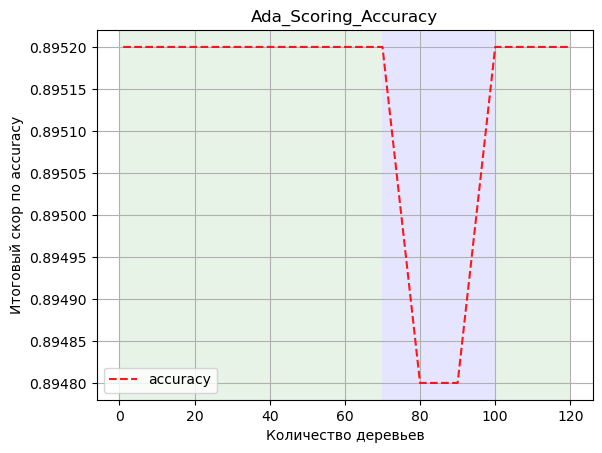

In [216]:
plt.title("Ada_Scoring_Accuracy")
plt.plot(ada_scoring_accuracy.keys(), ada_scoring_accuracy.values(), ls="--", color='red', alpha=0.9, label="accuracy")
plt.axvspan(70, 100, facecolor="blue", alpha=0.1)
plt.axvspan(0, 70, facecolor="green", alpha=0.09)
plt.axvspan(100, 120, facecolor="green", alpha=0.09)
plt.ylabel("Итоговый скор по accuracy")
plt.xlabel("Количество деревьев")
plt.grid()
plt.legend()

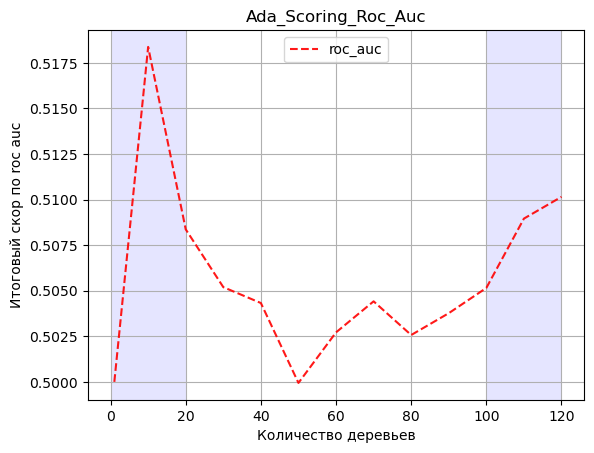

In [217]:
plt.title("Ada_Scoring_Roc_Auc")
plt.plot(ada_scoring_roc_auc.keys(), ada_scoring_roc_auc.values(), ls="--", color='red', alpha=0.9, label='roc_auc')
plt.axvspan(0, 20, facecolor="blue", alpha=0.1)
plt.axvspan(100, 120, facecolor="blue", alpha=0.1)
plt.ylabel("Итоговый скор по roc auc")
plt.xlabel("Количество деревьев")
plt.grid()
plt.legend()

#Так как время одинаковое -> мы можем взять любое количество деревьев, но чисто интуитивно скорее всего время будем меняться
#в большую сторону, так как количество деревьев растет -> выберем минимальное количество деревьев

In [218]:
data_ada = pd.DataFrame([['model_ada (10)', '0.523', '0.895', '0.0 ms', '0.0 ms']])
data_ada.columns = ['model', 'roc_auc_score', 'accuracy_score', 'Wall time', 'CPU times']

In [219]:
df_result_model = df_result_model.append(data_ada)
df_result_model

,model,roc_auc_score,accuracy_score,Wall time,CPU times
0,model_logistic_more_informative_features,0.5,0.8975,88.6 ms,78.1 ms
1,model_logistic_all_features,0.5,0.8975,164 ms,172 ms
0,knn_model_3,0.496,0.871,21 ms,15.6 ms
1,knn_model_4,0.496,0.871,35.1 ms,62.5 ms
2,knn_model_5,0.496,0.871,27 ms,31.2 ms
0,nb_gaussianNB,0.5,0.8975,6.88 ms,0 ns
0,model_db,0.500217,0.801,169 ms,172 ms
0,model_ada (10),0.523,0.895,0.0 ms,0.0 ms


In [220]:
import time

X = data_result[['Card Type', 'Gender', 'Geography', 'Surname', 'CreditScore', 'Age', 'Satisfaction Score', 'Point Earned']]
Y = data_result['Tenure_value']

trees = [1] + list(range(10, 130, 10))
targets = Y
data = X

gbc_scoring_accuracy = {} #считаем accuracy для количества деревьев равное tree из цикла
gbc_scoring_roc_auc = {} #считает roc_auc для количества деревьев равное tree из цикла

time_classifier = {} #время обучения GradientBoostingClassifier при количестве деревьев равным tree из цикла

for tree in trees:
    
    start = time.time()
    gbc = GradientBoostingClassifier(n_estimators=tree)
    end = time.time()
    
    time_classifier[tree] = ((end - start)*1000)
    
    score_accuracy = cross_val_score(gbc, data, targets, scoring='accuracy', cv=4)
    score_roc_auc = cross_val_score(gbc, data, targets, scoring='roc_auc', cv=4)
    
    gbc_scoring_accuracy[tree] = score_accuracy
    gbc_scoring_roc_auc[tree] = score_roc_auc

In [221]:
for key in gbc_scoring_roc_auc.keys():
    gbc_scoring_roc_auc[key] = max(list(gbc_scoring_roc_auc[key]))

In [222]:
for key in gbc_scoring_accuracy.keys():
    gbc_scoring_accuracy[key] = max(list(gbc_scoring_accuracy[key]))

In [223]:
gbc_scoring_accuracy

{1: 0.8952,
 10: 0.8952,
 20: 0.8952,
 30: 0.8952,
 40: 0.8952,
 50: 0.8952,
 60: 0.8952,
 70: 0.8952,
 80: 0.8948,
 90: 0.8948,
 100: 0.8948,
 110: 0.8948,
 120: 0.8948}

In [224]:
gbc_scoring_roc_auc

{1: 0.5139181657559572,
 10: 0.5162358703586216,
 20: 0.4970836829502896,
 30: 0.49951650533123226,
 40: 0.4989366528184243,
 50: 0.4936898403017962,
 60: 0.48865365068320266,
 70: 0.4840685522106024,
 80: 0.4854448492042377,
 90: 0.4874999147275717,
 100: 0.48840209701955806,
 110: 0.4885103930035678,
 120: 0.4901297164180123}

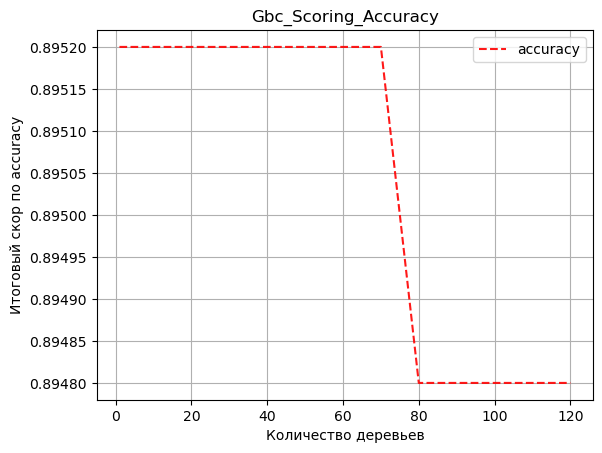

In [225]:
plt.title("Gbc_Scoring_Accuracy")
plt.plot(gbc_scoring_accuracy.keys(), gbc_scoring_accuracy.values(), ls="--", color='red', alpha=0.9, label="accuracy")
plt.ylabel("Итоговый скор по accuracy")
plt.xlabel("Количество деревьев")
plt.grid()
plt.legend()

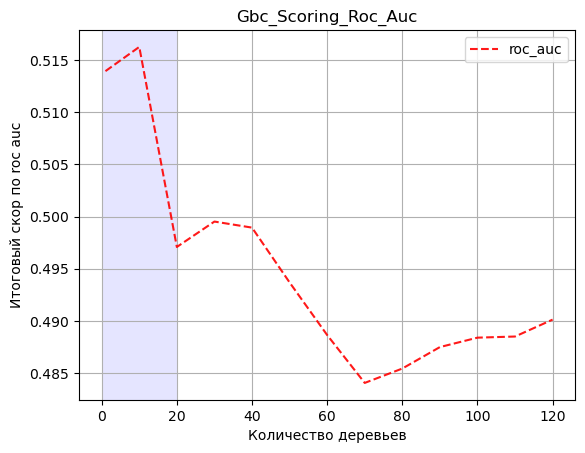

In [226]:
plt.title("Gbc_Scoring_Roc_Auc")
plt.plot(gbc_scoring_roc_auc.keys(), gbc_scoring_roc_auc.values(), ls="--", color='red', alpha=0.9, label="roc_auc")
plt.axvspan(0, 20, facecolor="blue", alpha=0.1)
plt.ylabel("Итоговый скор по roc auc")
plt.xlabel("Количество деревьев")
plt.grid()
plt.legend()

In [227]:
df_result_model

,model,roc_auc_score,accuracy_score,Wall time,CPU times
0,model_logistic_more_informative_features,0.5,0.8975,88.6 ms,78.1 ms
1,model_logistic_all_features,0.5,0.8975,164 ms,172 ms
0,knn_model_3,0.496,0.871,21 ms,15.6 ms
1,knn_model_4,0.496,0.871,35.1 ms,62.5 ms
2,knn_model_5,0.496,0.871,27 ms,31.2 ms
0,nb_gaussianNB,0.5,0.8975,6.88 ms,0 ns
0,model_db,0.500217,0.801,169 ms,172 ms
0,model_ada (10),0.523,0.895,0.0 ms,0.0 ms


In [228]:
data_gbc = pd.DataFrame([['gbc', '0.52', '0.895', '0.0 ms', '0.0 ms']])
data_gbc.columns = ['model', 'roc_auc_score', 'accuracy_score', 'Wall time', 'CPU times']

In [229]:
data_gbc

,model,roc_auc_score,accuracy_score,Wall time,CPU times
0,gbc,0.52,0.895,0.0 ms,0.0 ms


In [230]:
df_result_model = df_result_model.append(data_gbc)
df_result_model

,model,roc_auc_score,accuracy_score,Wall time,CPU times
0,model_logistic_more_informative_features,0.5,0.8975,88.6 ms,78.1 ms
1,model_logistic_all_features,0.5,0.8975,164 ms,172 ms
0,knn_model_3,0.496,0.871,21 ms,15.6 ms
1,knn_model_4,0.496,0.871,35.1 ms,62.5 ms
2,knn_model_5,0.496,0.871,27 ms,31.2 ms
0,nb_gaussianNB,0.5,0.8975,6.88 ms,0 ns
0,model_db,0.500217,0.801,169 ms,172 ms
0,model_ada (10),0.523,0.895,0.0 ms,0.0 ms
0,gbc,0.52,0.895,0.0 ms,0.0 ms


In [231]:
import time

X = data_result[['Card Type', 'Gender', 'Geography', 'Surname', 'CreditScore', 'Age', 'Satisfaction Score', 'Point Earned']]
Y = data_result['Tenure_value']

trees = [1] + list(range(10, 130, 10))
targets = Y
data = X

xgb_scoring_accuracy = {} #считаем accuracy для количества деревьев равное tree из цикла
xgb_scoring_roc_auc = {} #считает roc_auc для количества деревьев равное tree из цикла

time_classifier = {} #время обучения XGBClassifier при количестве деревьев равным tree из цикла

for tree in trees:
    
    start = time.time()
    xgb = XGBClassifier(n_estimators=tree)
    end = time.time()
    
    time_classifier[tree] = ((end - start)*1000)
    
    score_accuracy = cross_val_score(xgb, data, targets, scoring='accuracy', cv=4)
    score_roc_auc = cross_val_score(xgb, data, targets, scoring='roc_auc', cv=4)
    
    xgb_scoring_accuracy[tree] = score_accuracy
    xgb_scoring_roc_auc[tree] = score_roc_auc

In [232]:
xgb_scoring_accuracy

{1: array([0.8928, 0.89  , 0.8936, 0.7592]),
 10: array([0.8952, 0.8952, 0.8948, 0.7592]),
 20: array([0.8944, 0.8948, 0.8948, 0.776 ]),
 30: array([0.8936, 0.8944, 0.894 , 0.796 ]),
 40: array([0.894 , 0.8924, 0.894 , 0.7928]),
 50: array([0.8924, 0.8928, 0.8928, 0.788 ]),
 60: array([0.892 , 0.8924, 0.892 , 0.794 ]),
 70: array([0.8928, 0.8908, 0.8912, 0.7916]),
 80: array([0.8924, 0.8908, 0.8904, 0.7944]),
 90: array([0.8912, 0.8908, 0.8904, 0.7904]),
 100: array([0.8904, 0.8912, 0.8892, 0.7944]),
 110: array([0.8892, 0.8888, 0.8896, 0.7848]),
 120: array([0.888 , 0.8876, 0.888 , 0.7864])}

In [233]:
xgb_scoring_roc_auc

{1: array([0.48459127, 0.47671295, 0.49989853, 0.4964936 ]),
 10: array([0.50846499, 0.50369059, 0.50417238, 0.49274673]),
 20: array([0.50193057, 0.49439419, 0.48685184, 0.49648251]),
 30: array([0.50154258, 0.49356961, 0.50217189, 0.48654231]),
 40: array([0.49094833, 0.49167997, 0.49261882, 0.49176268]),
 50: array([0.49535606, 0.49256083, 0.4994048 , 0.49124082]),
 60: array([0.49672383, 0.49016724, 0.50174297, 0.49113508]),
 70: array([0.49761578, 0.49374953, 0.49974418, 0.48587206]),
 80: array([0.49157167, 0.49127834, 0.50086466, 0.48654572]),
 90: array([0.48994126, 0.49002313, 0.49775563, 0.48896745]),
 100: array([0.49821269, 0.4897639 , 0.49885223, 0.48869288]),
 110: array([0.49381775, 0.48847458, 0.50268779, 0.48730635]),
 120: array([0.49517188, 0.48794248, 0.50277135, 0.49066779])}

In [234]:
time_classifier

{1: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 0.0,
 100: 0.0,
 110: 0.0,
 120: 0.0}

In [235]:
for key in xgb_scoring_roc_auc.keys():
    xgb_scoring_roc_auc[key] = max(list(xgb_scoring_roc_auc[key]))

In [236]:
for key in xgb_scoring_accuracy.keys():
    xgb_scoring_accuracy[key] = max(list(xgb_scoring_accuracy[key]))

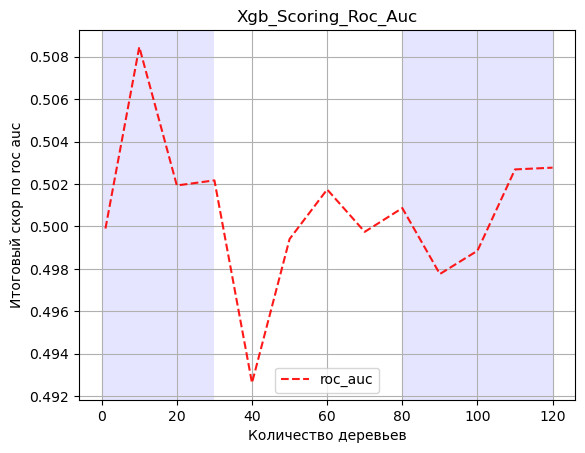

In [237]:
plt.title("Xgb_Scoring_Roc_Auc")
plt.plot(xgb_scoring_roc_auc.keys(), xgb_scoring_roc_auc.values(), ls="--", color='red', alpha=0.9, label="roc_auc")
plt.axvspan(0, 30, facecolor="blue", alpha=0.1)
plt.axvspan(80, 120, facecolor="blue", alpha=0.1)
plt.ylabel("Итоговый скор по roc auc")
plt.xlabel("Количество деревьев")
plt.grid()
plt.legend()

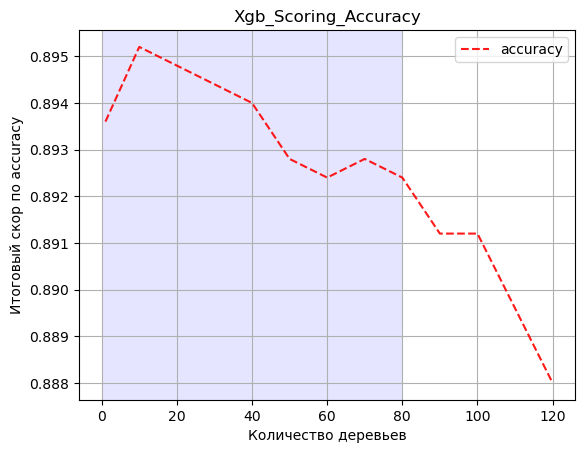

In [238]:
plt.title("Xgb_Scoring_Accuracy")
plt.plot(xgb_scoring_accuracy.keys(), xgb_scoring_accuracy.values(), ls="--", color='red', alpha=0.9, label="accuracy")
plt.ylabel("Итоговый скор по accuracy")
plt.axvspan(0, 80, facecolor="blue", alpha=0.1)
plt.xlabel("Количество деревьев")
plt.grid()
plt.legend()

In [239]:
data_xgb = pd.DataFrame([['xgb', '0.508', '0.895', '0 ms', '0.996 ms']])
data_xgb.columns = ['model', 'roc_auc_score', 'accuracy_score', 'Wall time', 'CPU times']

In [240]:
df_result_model = df_result_model.append(data_xgb)
df_result_model

,model,roc_auc_score,accuracy_score,Wall time,CPU times
0,model_logistic_more_informative_features,0.5,0.8975,88.6 ms,78.1 ms
1,model_logistic_all_features,0.5,0.8975,164 ms,172 ms
0,knn_model_3,0.496,0.871,21 ms,15.6 ms
1,knn_model_4,0.496,0.871,35.1 ms,62.5 ms
2,knn_model_5,0.496,0.871,27 ms,31.2 ms
0,nb_gaussianNB,0.5,0.8975,6.88 ms,0 ns
0,model_db,0.500217,0.801,169 ms,172 ms
0,model_ada (10),0.523,0.895,0.0 ms,0.0 ms
0,gbc,0.52,0.895,0.0 ms,0.0 ms
0,xgb,0.508,0.895,0 ms,0.996 ms
